In [1]:
import tensorflow as tf

In [2]:
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.11.0


In [3]:
import pandas as pd
df=pd.read_csv(r"C:\Users\USER\Documents\Workspace\tensorflow\DA\GlobalLandTemperaturesByCity.csv")

In [4]:
df.head()


,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [5]:
df.shape

(8599212, 7)

In [6]:
df=df[df['Country']=='India']
df.shape

(1014906, 7)

In [7]:
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
49880,1816-03-01,19.934,2.258,Abohar,India,29.74N,73.85E
49881,1816-04-01,26.641,3.398,Abohar,India,29.74N,73.85E
49882,1816-05-01,32.535,2.408,Abohar,India,29.74N,73.85E
49883,1816-06-01,33.254,2.123,Abohar,India,29.74N,73.85E
49884,1816-07-01,31.105,1.848,Abohar,India,29.74N,73.85E


In [8]:
df=df.dropna(subset=['AverageTemperature'])
df.shape

(960548, 7)

In [9]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)


In [10]:
TRAIN_SPLIT = 800000


In [11]:
uni_data = df['AverageTemperature']
uni_data.index = df['dt']
uni_data.head()

dt
1816-03-01    19.934
1816-04-01    26.641
1816-05-01    32.535
1816-06-01    33.254
1816-07-01    31.105
Name: AverageTemperature, dtype: float64

In [12]:
uni_data = uni_data.values
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data = (uni_data-uni_train_mean)/uni_train_std
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [13]:
y_train_uni.shape

(799980,)

In [14]:
def create_time_steps(length):
  return list(range(-length, 0))

In [15]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt
  

<module 'matplotlib.pyplot' from 'c:\\Users\\USER\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

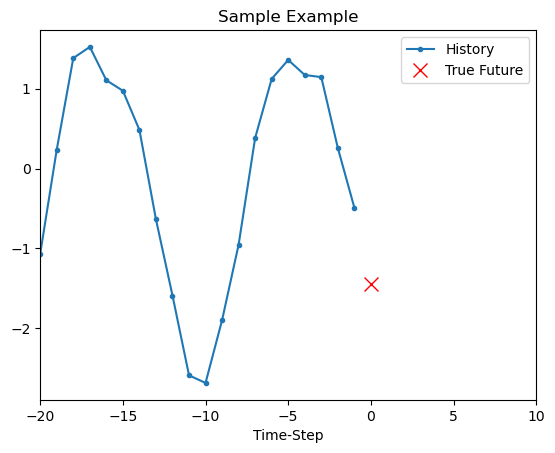

In [16]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')


## BaseLine

In [17]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from 'c:\\Users\\USER\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

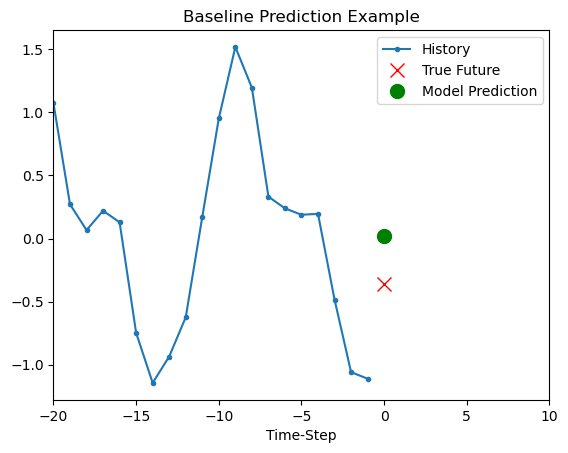

In [18]:
i=4000
show_plot([x_train_uni[i], y_train_uni[i], baseline(x_train_uni[i])], 0,
           'Baseline Prediction Example')

In [19]:
def error(X,Y):
    n_test=X.shape[0]
    error=0
    for i in range(n_test):
        error=error+abs(baseline(X[i])-Y[i])
    return error/n_test

In [20]:
error(x_val_uni,y_val_uni)

0.7224525547809727

## DENSE Network

In [35]:
x_train = x_train_uni.reshape(-1, 20)
x_test = x_val_uni.reshape(-1, 20)

In [36]:
x_test.shape

(160528, 20)

In [41]:
model = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(20)),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1),
    ]
)

In [42]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 10)                210       
                                                                 
 dense_7 (Dense)             (None, 10)                110       
                                                                 
 dense_8 (Dense)             (None, 1)                 11        
                                                                 
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________


In [43]:
model.compile(
    loss='mae',
    optimizer='adam',
)

In [44]:
model.fit(x_train, y_train_uni, epochs=20, verbose=2)
model.evaluate(x_test, y_val_uni, batch_size=32, verbose=2)

Epoch 1/20
25000/25000 - 12s - loss: 0.1441 - 12s/epoch - 464us/step
Epoch 2/20
25000/25000 - 12s - loss: 0.1340 - 12s/epoch - 461us/step
Epoch 3/20
25000/25000 - 11s - loss: 0.1327 - 11s/epoch - 457us/step
Epoch 4/20
25000/25000 - 11s - loss: 0.1319 - 11s/epoch - 444us/step
Epoch 5/20
25000/25000 - 11s - loss: 0.1313 - 11s/epoch - 451us/step
Epoch 6/20
25000/25000 - 12s - loss: 0.1310 - 12s/epoch - 462us/step
Epoch 7/20
25000/25000 - 11s - loss: 0.1307 - 11s/epoch - 450us/step
Epoch 8/20
25000/25000 - 11s - loss: 0.1305 - 11s/epoch - 443us/step
Epoch 9/20
25000/25000 - 11s - loss: 0.1304 - 11s/epoch - 429us/step
Epoch 10/20
25000/25000 - 11s - loss: 0.1302 - 11s/epoch - 428us/step
Epoch 11/20
25000/25000 - 11s - loss: 0.1301 - 11s/epoch - 442us/step
Epoch 12/20
25000/25000 - 11s - loss: 0.1300 - 11s/epoch - 452us/step
Epoch 13/20


KeyboardInterrupt: 

## LSTM

In [64]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE)

In [65]:
train_univariate

<BatchDataset element_spec=(TensorSpec(shape=(None, 20, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [66]:
tf.keras.backend.clear_session()

simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(16, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')
simple_lstm_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 16)                1152      
                                                                 
 dense (Dense)               (None, 10)                170       
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dense_2 (Dense)             (None, 1)                 6         
                                                                 
Total params: 1,383
Trainable params: 1,383
Non-trainable params: 0
_________________________________________________________________


In [67]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

8/8 [==============================] - 0s 2ms/step
(256, 1)


In [68]:
EVALUATION_INTERVAL = 400

EPOCHS = 20

singlehistory = simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      
                      validation_data=val_univariate)

Epoch 1/20
3125/3125 [==============================] - 50s 16ms/step - loss: 0.1839 - val_loss: 0.1536
Epoch 2/20
3125/3125 [==============================] - 59s 19ms/step - loss: 0.1465 - val_loss: 0.1431
Epoch 3/20
3125/3125 [==============================] - 56s 18ms/step - loss: 0.1407 - val_loss: 0.1369
Epoch 4/20
3125/3125 [==============================] - 53s 17ms/step - loss: 0.1365 - val_loss: 0.1343
Epoch 5/20
3125/3125 [==============================] - 53s 17ms/step - loss: 0.1345 - val_loss: 0.1310
Epoch 6/20
3125/3125 [==============================] - 53s 17ms/step - loss: 0.1332 - val_loss: 0.1321
Epoch 7/20
3125/3125 [==============================] - 53s 17ms/step - loss: 0.1323 - val_loss: 0.1307
Epoch 8/20
3125/3125 [==============================] - 54s 17ms/step - loss: 0.1316 - val_loss: 0.1293
Epoch 9/20
3125/3125 [==============================] - 54s 17ms/step - loss: 0.1310 - val_loss: 0.1303
Epoch 10/20
3125/3125 [==============================] - 57s 18m

KeyboardInterrupt: 

In [69]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

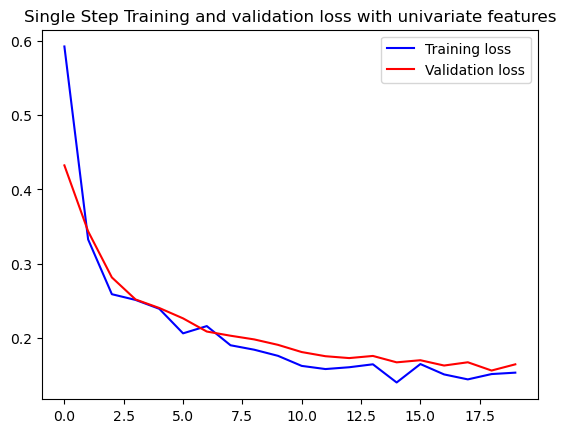

In [70]:
plot_train_history(singlehistory,
                   'Single Step Training and validation loss with univariate features')

8/8 [==============================] - 0s 3ms/step


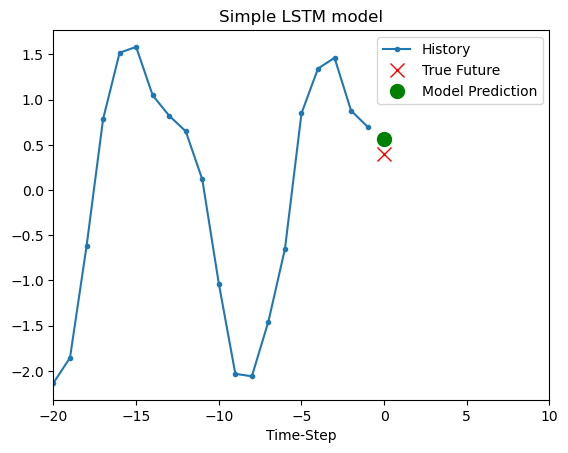

8/8 [==============================] - 0s 3ms/step


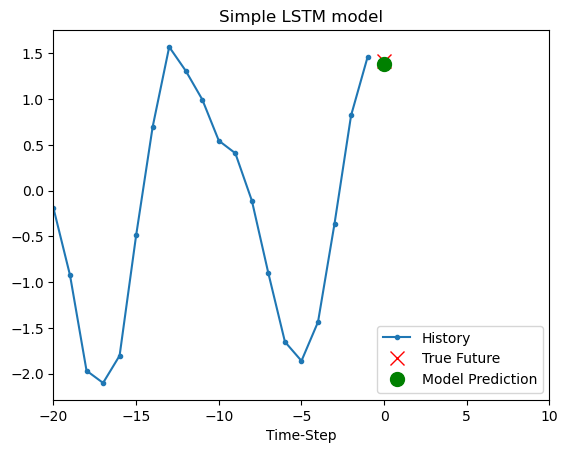

8/8 [==============================] - 0s 3ms/step


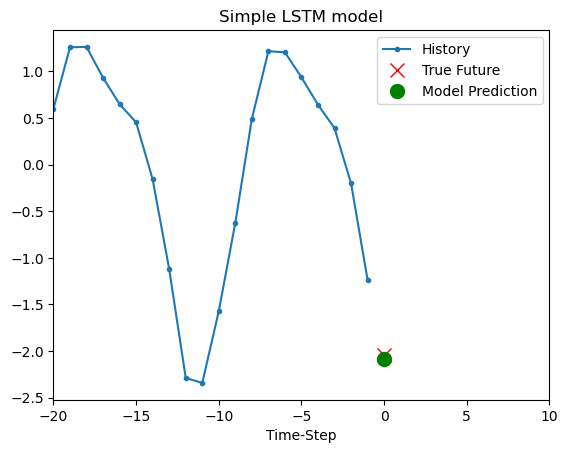

In [71]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

 ## Forecast a multivariate time series

In [78]:
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
49880,1816-03-01,19.934,2.258,Abohar,India,29.74N,73.85E
49881,1816-04-01,26.641,3.398,Abohar,India,29.74N,73.85E
49882,1816-05-01,32.535,2.408,Abohar,India,29.74N,73.85E
49883,1816-06-01,33.254,2.123,Abohar,India,29.74N,73.85E
49884,1816-07-01,31.105,1.848,Abohar,India,29.74N,73.85E


In [79]:
features_considered = ['AverageTemperature', 'AverageTemperatureUncertainty']
features = df[features_considered]
features.index = df['dt']
features

,AverageTemperature,AverageTemperatureUncertainty
dt,,
1816-03-01,19.934,2.258
1816-04-01,26.641,3.398
1816-05-01,32.535,2.408
1816-06-01,33.254,2.123
1816-07-01,31.105,1.848
...,...,...
2013-04-01,29.800,0.375
2013-05-01,29.286,0.516
2013-06-01,25.401,0.400


array([<AxesSubplot:xlabel='dt'>, <AxesSubplot:xlabel='dt'>], dtype=object)

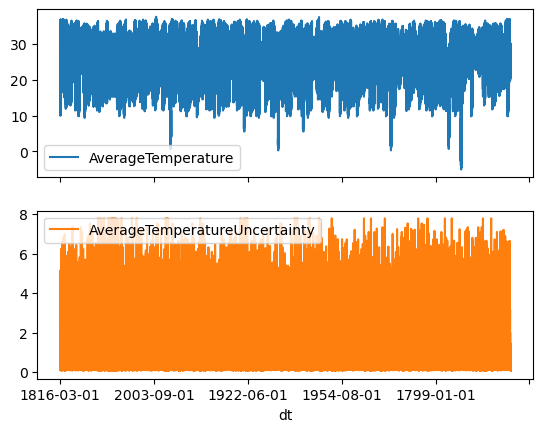

In [80]:
features.plot(subplots=True)


In [81]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [82]:
dataset = (dataset-data_mean)/data_std


In [83]:
dataset.shape

(960548, 2)

In [84]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i )
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [85]:
past_history = 20
future_target = 0
# STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 0], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 0],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, 
                                               single_step=True)

In [86]:
x_val_single.shape

(160528, 20, 2)

In [87]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))


Single window of past history : (20, 2)


In [88]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE)

In [89]:
single_step_model = tf.keras.models.Sequential()
single_step_model=tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_single.shape[-2:]),
    tf.keras.layers.Dense(1)
])

single_step_model.compile(optimizer='adam', loss='mae')
single_step_model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 8)                 352       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 361
Trainable params: 361
Non-trainable params: 0
_________________________________________________________________


In [90]:
x_train_single.shape[-2:]

(20, 2)

In [91]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

8/8 [==============================] - 0s 5ms/step
(256, 1)


In [93]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            # steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            )

Epoch 1/20
3125/3125 [==============================] - 53s 17ms/step - loss: 0.2247 - val_loss: 0.1665
Epoch 2/20
3125/3125 [==============================] - 52s 17ms/step - loss: 0.1571 - val_loss: 0.1563
Epoch 3/20
3125/3125 [==============================] - 49s 16ms/step - loss: 0.1521 - val_loss: 0.1542
Epoch 4/20
3125/3125 [==============================] - 51s 16ms/step - loss: 0.1485 - val_loss: 0.1512
Epoch 5/20
3125/3125 [==============================] - 51s 16ms/step - loss: 0.1452 - val_loss: 0.1479
Epoch 6/20
3125/3125 [==============================] - 51s 16ms/step - loss: 0.1423 - val_loss: 0.1431
Epoch 7/20
3125/3125 [==============================] - 55s 18ms/step - loss: 0.1405 - val_loss: 0.1407
Epoch 8/20
3125/3125 [==============================] - 54s 17ms/step - loss: 0.1394 - val_loss: 0.1390
Epoch 9/20
3125/3125 [==============================] - 52s 17ms/step - loss: 0.1385 - val_loss: 0.1392
Epoch 10/20
3125/3125 [==============================] - 51s 16m

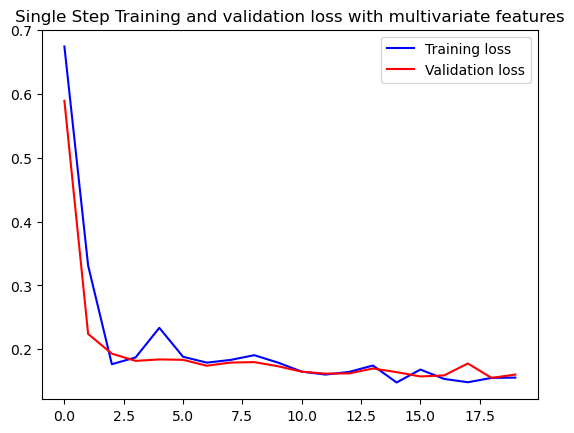

In [45]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss with multivariate features')